In [1]:
import os
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
from seisbench.util import worker_seeding
from seisbench.models import SeisBenchModel 

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Aqui hay 4 clases

In [2]:
data = sbd.TXED(cache="full", sampling_rate=100, force=True) #Esta accion es recomendable hacerla en terminal pues tarda mucho        cache="full"
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-12-18 20:27:57,458 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Preloading waveforms: 100%|██████████| 2167/2167 [00:24<00:00, 87.21it/s] 

TXED - 2167 traces


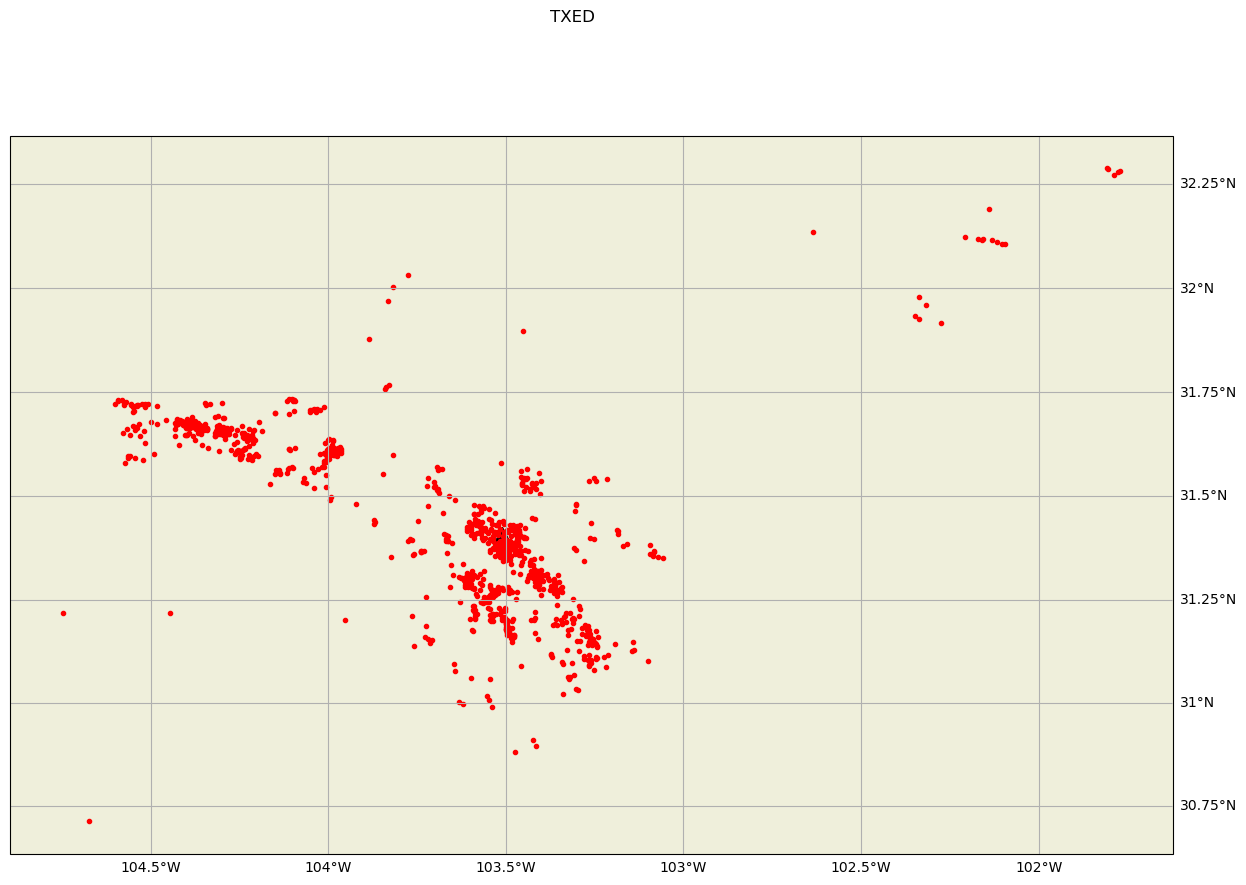

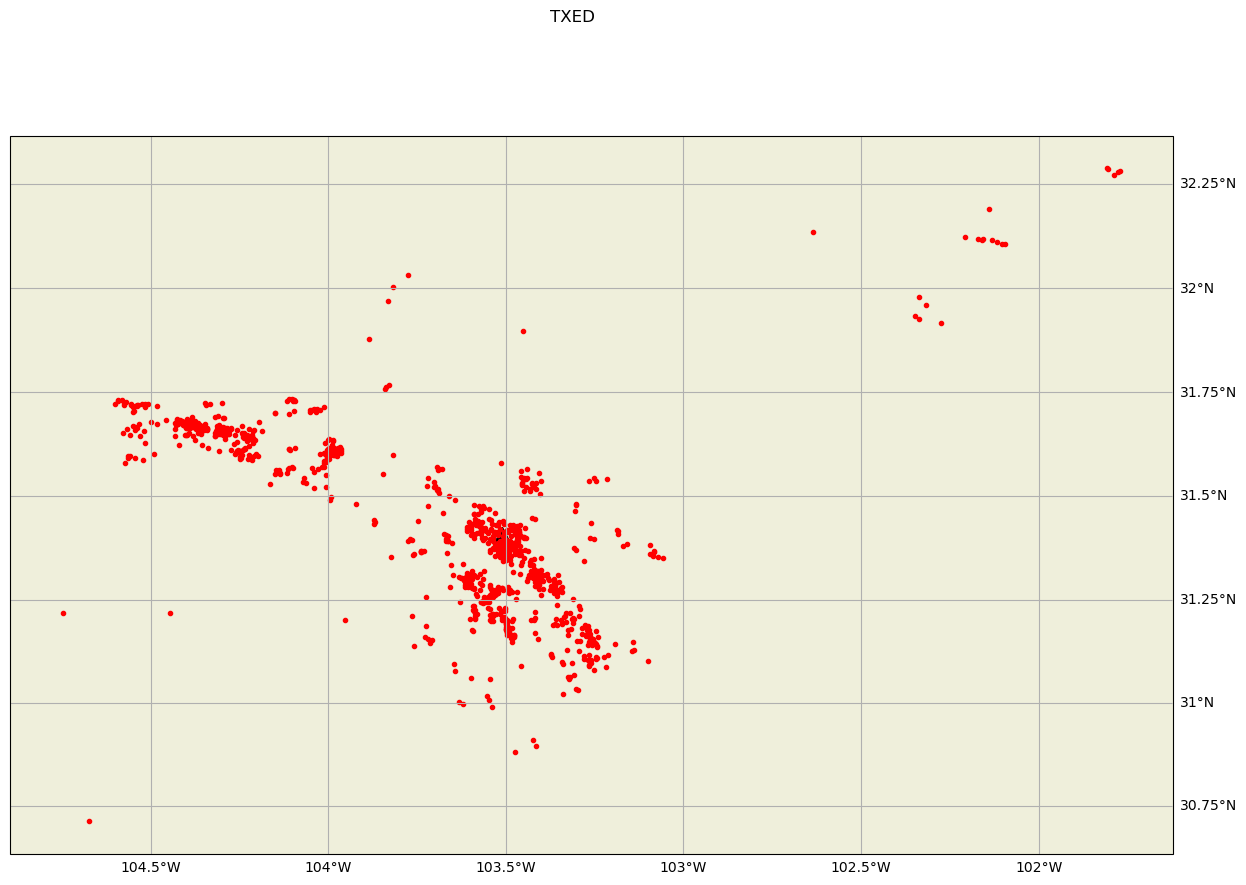

In [4]:
data.plot_map()

In [5]:
train = data.train()
dev = data.dev()

In [6]:
print(len(train))
print(len(dev))

1938
229


In [7]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

In [8]:
train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

In [9]:
@train_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)


@dev_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

print(dev_generator[1])

{'X': array([[-2.30132253e-05, -1.59618949e-05,  1.11387719e-05, ...,
        -1.41606676e-02, -1.34759752e-02, -1.27882345e-02],
       [ 8.38023679e-05,  1.03381874e-04,  1.88201492e-04, ...,
         3.24461186e-03,  2.37291553e-03,  1.57538327e-03],
       [ 6.10983501e-05,  6.78959435e-05,  1.00440681e-04, ...,
        -8.57778022e-03, -8.62191457e-03, -8.66029497e-03]]), 'y': 0}


In [10]:
batch_size = 150 #128
num_workers = 0  # The number of threads used for loading data

#worker_init_fn es principalmente usado cuando se trabaja en parallelo para que todos los "workers" tengan mismas condiciones 
train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)

### Model

In [11]:
import torch.nn as nn
class modelo_convnetquake(SeisBenchModel):  #               
    def __init__(self, citation=None, num_classes=10, regularization=0.000875, input_length=3001, sampling_rate=100):
        self.regularization = regularization

        super().__init__()
        # Parámetros
        c = 32  # número de canales por capa conv
        ksize = 3  # tamaño del kernel de la convolución
        depth = 8  # profundidad de la red
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Capas convolucionales
        layers = []
        in_channels = 3
        for i in range(depth):
            layers.append(nn.Conv1d(in_channels, c, kernel_size=ksize, stride=2, padding=1))
            layers.append(nn.ReLU())
            in_channels = c
            self.conv_layers = nn.Sequential(*layers)

        # Dummy input para calcular el tamaño de la salida
        dummy_input = torch.zeros(1, 3, input_length).to(self.device)
        output_size = self.conv_layers(dummy_input).numel()

        # Capa completamente conectada
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        return logits
    
    def loss_func(self,logits,targets):
        loss = nn.CrossEntropyLoss()(logits, targets)
        reg_loss = self.regularization * sum(param.norm(2) for param in self.parameters())
        return loss + reg_loss

    def accuracy(self, logits,targets):
        # hay dos accuracies en el modelo original, se enfocara en "location accuracy"
        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).float()
        accuracy = correct.sum() / len(correct)
        return accuracy


In [12]:
learning_rate = 0.001

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = modelo_convnetquake(input_length=6001,num_classes=5)
model.to(device)

modelo_convnetquake(
  (conv_layers): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): ReLU()
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): ReLU()
    (10): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): ReLU()
    (14): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (15): ReLU()
  )
  (fc): Linear(in_features=768, out_features=5, bias=True)
)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
for batch_id, batch in enumerate(train_loader):
    print(len(batch['y']))


150
150
150
150
150
150
150
150
150
150
150
150
138


In [16]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

epoch = 35
for i in range(epoch):
    running_loss = 0
    running_acc = 0
    model.train()  # Set the model to training mode
    for batch_id, batch in enumerate(train_loader):
    ################## Train 
        # Reset the gradients to zero
        optimizer.zero_grad()

        # Forward pass
        output = model(batch['X'].float())

        # Calculate the loss
        loss = model.loss_func(output,batch['y'])
        acc = model.accuracy(output,batch['y'])

        # Backpropagation
        loss.backward()

        # Update the model's weights
        optimizer.step()

        running_loss += loss.item()
        running_acc += acc.item()
    print("Epoch {} - Training loss: {}".format(i + 1, running_loss / len(train_loader)))
    train_loss.append(running_loss / len(train_loader))

    train_acc.append(running_acc/len(train_loader))

    ################## Test
"""     model.eval()
    running_loss2 = 0
    running_acc2 = 0
    for batch_id, batch in enumerate(test_loader):
        output = model(batch['X'].float())
        loss2 = model.loss_func(output,batch['y'])
        acc2 = model.accuracy(output,batch['y'])
        running_loss2 += loss.item()
        running_acc2 += acc2.item()

    test_loss.append(running_loss2 / len(test_loader))

    test_acc.append(running_acc2/len(test_loader))
     """



Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])
Input shape: torch.Size([150, 3, 6000])
Shape after conv layers: torch.Size([150, 32, 24])

"     model.eval()\n    running_loss2 = 0\n    running_acc2 = 0\n    for batch_id, batch in enumerate(test_loader):\n        output = model(batch['X'].float())\n        loss2 = model.loss_func(output,batch['y'])\n        acc2 = model.accuracy(output,batch['y'])\n        running_loss2 += loss.item()\n        running_acc2 += acc2.item()\n\n    test_loss.append(running_loss2 / len(test_loader))\n\n    test_acc.append(running_acc2/len(test_loader))\n     "

In [17]:
len(train_loader)

13

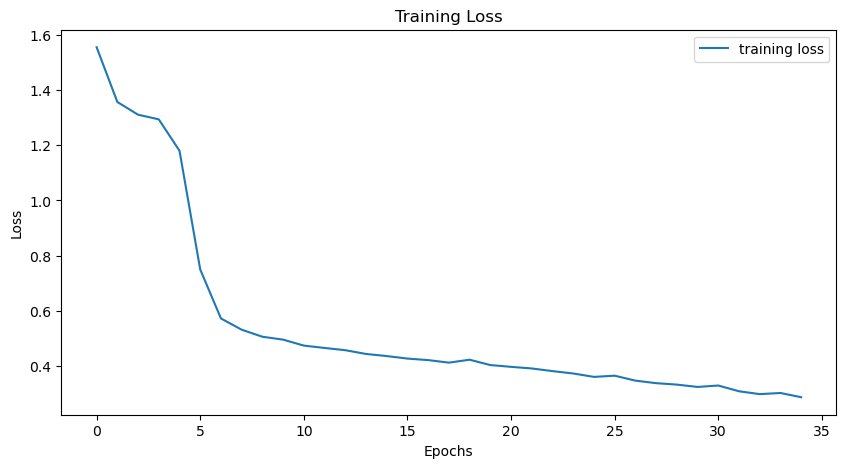

In [18]:
plt.figure(figsize=(10,5))
plt.plot(train_loss,label='training loss')
#plt.plot(test_loss,label='testing loss')
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Text(0, 0.5, 'Accuracy')

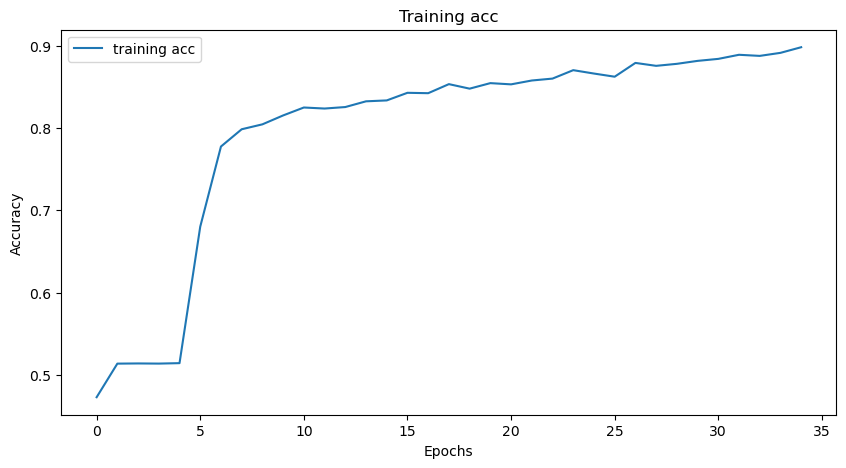

In [19]:
plt.figure(figsize=(10,5))
plt.plot(train_acc,label='training acc')
#plt.plot(test_acc,label='testing acc')
plt.title("Training acc")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [19]:
#save the model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
   
}
# Specify the path to save the model to:
#save_path = "/home/jbg/Documents/geofisica_lapaz/modelo_entrenadop"

torch.save(model.state_dict(),"modelo_entrenado.pth")

### Prueba

2


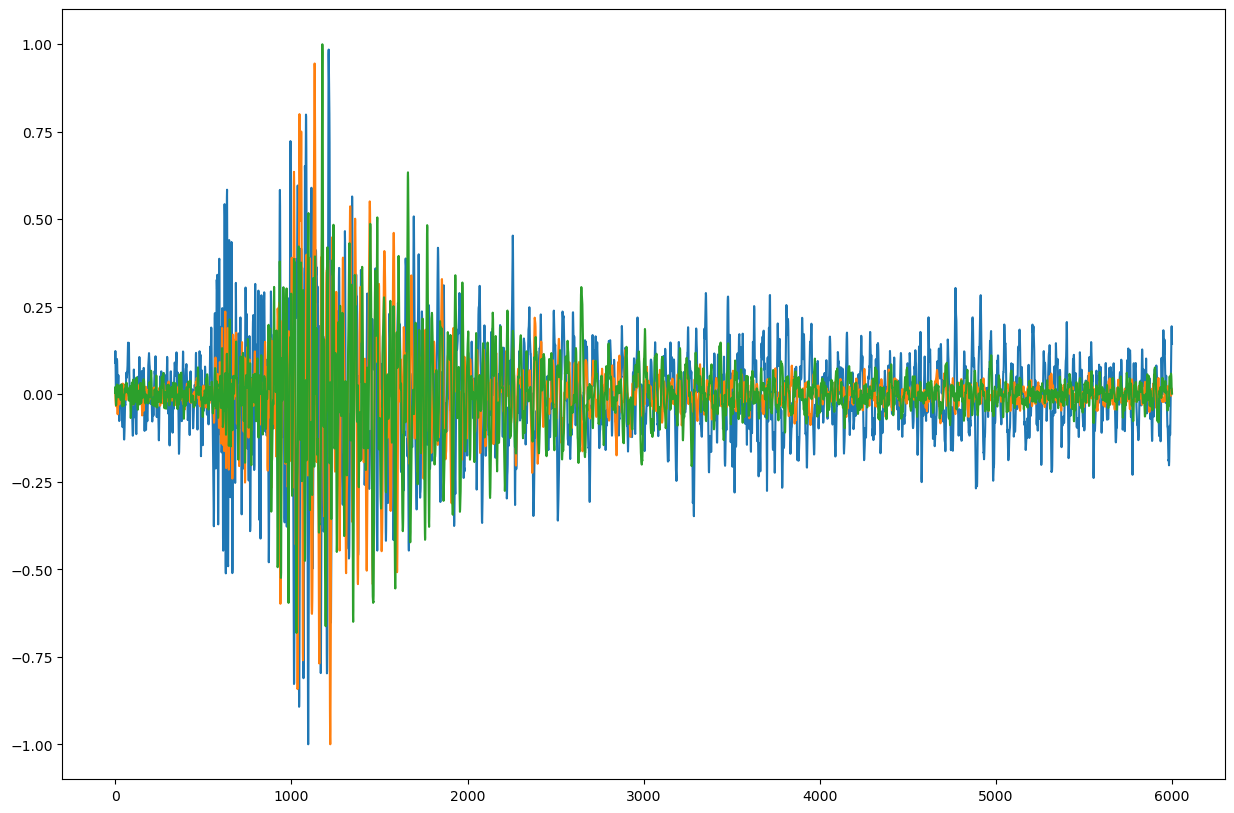

In [20]:
sample = dev_generator[np.random.randint(len(dev_generator))]
fig = plt.figure(figsize=(15, 10))
#axs = fig.plot(1, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
plt.plot(sample["X"].T)
print(sample["y"])

In [21]:
model.eval()
with torch.no_grad():
    pred = model(torch.tensor(sample['X']).float().unsqueeze(0))  # unsqueeze(0) to add a fake batch dimension
    prob = torch.softmax(pred,dim=1)
    print(prob)

Input shape: torch.Size([1, 3, 6000])
Shape after conv layers: torch.Size([1, 32, 24])
tensor([[0.0463, 0.0980, 0.3237, 0.5320]])


### Prediccion de todos los eventos

#### Carga del modelo

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = modelo_convnetquake(input_length=6001,num_classes=4)
model.to(device)
model.load_state_dict(torch.load('modelo_entrenado_4cross.pth'))
# model otrch.load("modelo.pth") si lo que se tiene es el modelo completo y no solo el diccionario

<All keys matched successfully>

In [23]:
data_generator = sbg.GenericGenerator(data)
data_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

@data_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

In [24]:
batch_size = 124
num_workers = 0  # The number of threads used for loading data
data_loader = DataLoader(data_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)

In [25]:
model.eval()
full_prob = []
for batch_id, batch in enumerate(data_loader):
    output = model(batch['X'].float())
    prob = torch.softmax(output,dim=1)
    full_prob.append(prob)  

full_prob = torch.cat(full_prob, dim=0)

Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([124, 3, 6000])
Shape after conv layers: torch.Size([124, 32, 24])
Input shape: torch.Size([54, 3, 6000])
Shape after conv layers: torch.Size([54, 32, 24])


In [26]:
print(type(full_prob))
print(len(full_prob))

<class 'torch.Tensor'>
1046


In [27]:
full_prob = full_prob.detach().numpy()
data.metadata['prob'] = list(full_prob)
data.metadata.head()

,index,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,...,trace_name_original,split,trace_name,trace_causal,trace_polarity,ID_poligono,trace_chunk,trace_sampling_rate_hz,trace_component_order,prob
0,0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,...,texnet2019gknw_PCOS_EV,train,"bucket268$338,:3,:6000",unknown,unknown,2,,100,ZNE,"[0.0069500227, 0.65860355, 0.11983126, 0.21461..."
1,1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,...,texnet2019glly_PCOS_EV,train,"bucket268$343,:3,:6000",unknown,unknown,1,,100,ZNE,"[0.0006564374, 0.9975242, 0.0011213999, 0.0006..."
2,2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,...,texnet2019gmcy_PCOS_EV,train,"bucket267$962,:3,:6000",unknown,unknown,2,,100,ZNE,"[0.00029334577, 0.99945897, 0.00021409261, 3.3..."
3,3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,...,texnet2019gmhw_PCOS_EV,train,"bucket268$388,:3,:6000",unknown,unknown,2,,100,ZNE,"[0.0027246596, 0.95452696, 0.0070289494, 0.035..."
4,4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,...,texnet2019gmkl_PCOS_EV,train,"bucket268$401,:3,:6000",unknown,unknown,2,,100,ZNE,"[0.0029725814, 0.9598165, 0.01189235, 0.025318..."


In [28]:
#para guardar el archivo
data.metadata.to_csv("/Users/lamb/Documents/Modelo_Velocidades/metadata_cross.csv",index=False)